# Partie Exploration et nettoyage

### import des librairies

In [719]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import SelectKBest,chi2
import statsmodels
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE,RFECV
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, validation_curve,learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error , mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler, OrdinalEncoder,PowerTransformer,PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from scipy import spatial,stats
from scipy.stats import kstest
import folium
import warnings
warnings.filterwarnings('ignore')

### chargement du fichiers et description rapide

In [720]:
df1 =  pd.read_csv("2016_Building_Energy_Benchmarking.csv")

In [721]:
df1.shape

(3376, 46)

In [722]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [723]:
df1.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


### selection des batiments non destinés à l'habitation

In [724]:
df1['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [725]:
df1 = df1[~df1['BuildingType'].str.contains("Multifamily")]
df1['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [726]:
df1.shape

(1668, 46)

In [727]:
for column in df1.columns:
    if df1[column].nunique()<20:
        print('Colonne {}, valeurs uniques :\n{}\n'.format(column, df1[column].unique()))
    else:
        print('Colonne {}, {} valeurs uniques'.format(column, df1[column].nunique()))

Colonne OSEBuildingID, 1668 valeurs uniques
Colonne DataYear, valeurs uniques :
[2016]

Colonne BuildingType, valeurs uniques :
['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']

Colonne PrimaryPropertyType, 22 valeurs uniques
Colonne PropertyName, 1664 valeurs uniques
Colonne Address, 1647 valeurs uniques
Colonne City, valeurs uniques :
['Seattle']

Colonne State, valeurs uniques :
['WA']

Colonne ZipCode, 48 valeurs uniques
Colonne TaxParcelIdentificationNumber, 1587 valeurs uniques
Colonne CouncilDistrictCode, valeurs uniques :
[7 3 2 4 5 6 1]

Colonne Neighborhood, valeurs uniques :
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']

Colonne Latitude, 1497 valeurs uniques
Colonne Longitude, 1408 valeurs uniques
Colonne YearBuilt, 113 valeurs uniques
Colon

In [728]:
df1['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
df1['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)
df1['Neighborhood'].replace('North', 'NORTH', inplace=True)
df1['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)
df1['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
df1['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)

### Taux de remplissage des colonnes

In [729]:
taux_rempli = df1.count() / len(df1) * 100
taux_rempli.sort_values(ascending=False)

OSEBuildingID                      100.000000
Neighborhood                       100.000000
DataYear                           100.000000
DefaultData                        100.000000
PropertyGFABuilding(s)             100.000000
PropertyGFAParking                 100.000000
PropertyGFATotal                   100.000000
NumberofFloors                     100.000000
ComplianceStatus                   100.000000
Longitude                          100.000000
Latitude                           100.000000
YearBuilt                          100.000000
CouncilDistrictCode                100.000000
Address                            100.000000
BuildingType                       100.000000
TaxParcelIdentificationNumber      100.000000
PropertyName                       100.000000
PrimaryPropertyType                100.000000
City                               100.000000
State                              100.000000
TotalGHGEmissions                   99.880096
NaturalGas(kBtu)                  

### recherche des doublons

In [730]:
duplicates = df1[df1.duplicated()]
duplicates

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


### suppression de certaines colonnes inutiles pour notre annalyse

In [731]:
df1.drop(['State','Comments','ZipCode','City',"DefaultData","PropertyGFAParking","ComplianceStatus","GHGEmissionsIntensity",
          "Address","TaxParcelIdentificationNumber","ListOfAllPropertyUseTypes",'ThirdLargestPropertyUseTypeGFA',
          'SecondLargestPropertyUseTypeGFA',"PropertyName","SiteEnergyUse(kBtu)","SiteEUI(kBtu/sf)"], axis=1, inplace=True)

In [732]:
#Suppression des variables avec suffixe WN  qui est une correction des valeurs climatiques ascociée aux surfaces
df1.drop(["SiteEUIWN(kBtu/sf)","SourceEUIWN(kBtu/sf)"], axis=1, inplace=True)

In [733]:
#Suppression des variables redondantes
df1.drop(["Electricity(kWh)","NaturalGas(therms)"], axis=1, inplace=True)

### Vérification des valeurs négatives

In [734]:
df1.min()

OSEBuildingID                                  1
DataYear                                    2016
BuildingType                              Campus
PrimaryPropertyType          Distribution Center
CouncilDistrictCode                            1
Neighborhood                             BALLARD
Latitude                                47.49917
Longitude                             -122.41182
YearBuilt                                   1900
NumberofBuildings                            0.0
NumberofFloors                                 0
PropertyGFATotal                           11285
PropertyGFABuilding(s)                      3636
LargestPropertyUseTypeGFA                 5656.0
ENERGYSTARScore                              1.0
SourceEUI(kBtu/sf)                           0.0
SiteEnergyUseWN(kBtu)                        0.0
SteamUse(kBtu)                               0.0
Electricity(kBtu)                      -115417.0
NaturalGas(kBtu)                             0.0
TotalGHGEmissions   

### Visualisation de la carte de seattle

In [735]:
map_osm = folium.Map()
map_osm = folium.Map(location=[df1['Latitude'].mean(), df1['Longitude'].mean()],zoom_start=11)
for i in range(0,len(df1)):
    folium.Circle([df1.iloc[i]['Latitude'],df1.iloc[i]['Longitude']], 
                      popup=df1.iloc[i]['OSEBuildingID'], radius =100).add_to(map_osm)
map_osm

In [736]:
df1_nan = df1.isna().sum().sort_values(ascending=False)
df1_nan

Outlier                         1651
YearsENERGYSTARCertified        1570
ThirdLargestPropertyUseType     1315
SecondLargestPropertyUseType     813
ENERGYSTARScore                  574
LargestPropertyUseType             6
LargestPropertyUseTypeGFA          6
SiteEnergyUseWN(kBtu)              3
NaturalGas(kBtu)                   2
Electricity(kBtu)                  2
SteamUse(kBtu)                     2
SourceEUI(kBtu/sf)                 2
TotalGHGEmissions                  2
NumberofBuildings                  2
DataYear                           0
PropertyGFABuilding(s)             0
PropertyGFATotal                   0
NumberofFloors                     0
YearBuilt                          0
Longitude                          0
Latitude                           0
Neighborhood                       0
CouncilDistrictCode                0
PrimaryPropertyType                0
BuildingType                       0
OSEBuildingID                      0
dtype: int64

<AxesSubplot:title={'center':'Proportion de NaN (%)'}>

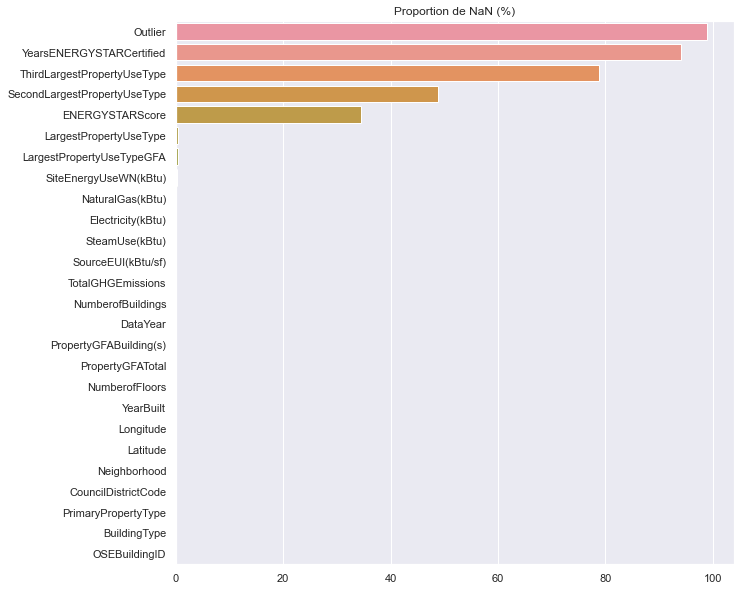

In [737]:
plt.figure(figsize=(10,10))
plt.title('Proportion de NaN (%)')
sns.barplot(x=df1_nan.values/df1.shape[0]*100, y=df1_nan.index)

In [738]:
df1.drop(['ThirdLargestPropertyUseType','SecondLargestPropertyUseType'], axis=1, inplace=True)

In [739]:
df1 = df1.drop(['Outlier',"YearsENERGYSTARCertified"],axis=1)
df1.shape

(1668, 22)

In [740]:
df1.dropna(how = 'all', axis=0, inplace=True)
df1.shape

(1668, 22)

### Compte et suppression des lignes nan dans  LargestPropertyUseTypeGFA et LargestPropertyUseType

In [741]:
df1['LargestPropertyUseTypeGFA'].isna().sum()

6

In [742]:
df1= df1.dropna(subset=['LargestPropertyUseTypeGFA'])

In [743]:
df1['LargestPropertyUseType'].isna().sum()

0

### Catégories de colonnes

In [744]:
columns_to_categorize = ['BuildingType', 'CouncilDistrictCode', 'Neighborhood']

In [745]:
df1[columns_to_categorize] = df1[columns_to_categorize].astype('category')

In [746]:
df1.select_dtypes(['object', 'category']).nunique().sort_values(ascending=False)

LargestPropertyUseType    56
PrimaryPropertyType       22
Neighborhood              13
CouncilDistrictCode        7
BuildingType               5
dtype: int64

In [747]:
property_use_types_columns = ['LargestPropertyUseType','PrimaryPropertyType']

In [748]:
 usetype_dict = {'Retail Store' : 'Retail',
                'Supermarket/Grocery Store' : 'Retail',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
                'Automobile Dealership': 'Retail',
                'Convenience Store without Gas Station': 'Retail',
                'Personal Services': 'Retail',
                'Enclosed Mall': 'Retail',
                'Strip Mall': 'Retail',
                'Wholesale Club/Supercenter': 'Retail',
                'Other - Mall': 'Retail',
                'Supermarket / Grocery Stor': 'Retail',
                
                'Food Sales': 'Leisure',
                'Restaurant' : 'Leisure',
                'Other - Restaurant/Bar' : 'Leisure',
                'Food Service': 'Leisure' ,
                'Worship Facility': 'Leisure',
                'Other - Recreation': 'Leisure',
                'Other - Entertainment/Public Assembly': 'Leisure',
                'Performing Arts': 'Leisure',
                'Bar/Nightclub': 'Leisure',
                'Movie Theater': 'Leisure',
                'Museum': 'Leisure',
                'Social/Meeting Hall': 'Leisure',
                'Fitness Center/Health Club/Gym': 'Leisure',
                'Lifestyle Center ': 'Leisure',
                'Fast Food Restaurant': 'Leisure',
                 
                'Multifamily Housing' : 'Hotel/Senior Care/Housing',
                'Other - Lodging/Residential': 'Hotel/Senior Care/Housing',
                'Residence Hall/Dormitory': 'Hotel/Senior Care/Housing',
                'Hotel' : 'Hotel/Senior Care/Housing',
                'Senior Care Community' : 'Hotel/Senior Care/Housing',
                'Residential Care Facility' : 'Hotel/Senior Care/Housing',
                'High-Rise Multifamily': 'Hotel/Senior Care/Housing',
                
                'Medical Office' : 'Health',
                
                'Other - Services' : 'Office',
                'Bank Branch' : 'Office',
                'Financial Office' : 'Office',
                'Other - Public Services': 'Office',

                'K-12 School' : 'Education',
                'Other - Education': 'Education',
                'Vocational School' : 'Education', 
                'Adult Education' : 'Education',
                'Pre-school/Daycare': 'Education',
                'University': 'Education',
                'College/University': 'Education',
                'Library': 'Education'
               }

In [749]:
for column in property_use_types_columns:
    df1[column] = df1[column].replace(usetype_dict)

In [750]:
for column in df1[property_use_types_columns].columns:
    print(df1[column].value_counts())
    print('\n')

Office                                                  512
Non-Refrigerated Warehouse                              199
Education                                               175
Leisure                                                 162
Retail                                                  162
Hotel/Senior Care/Housing                               136
Other                                                    98
Distribution Center                                      54
Health                                                   41
Parking                                                  30
Self-Storage Facility                                    27
Laboratory                                               13
Refrigerated Warehouse                                   12
Hospital (General Medical & Surgical)                    10
Manufacturing/Industrial Plant                            8
Urgent Care/Clinic/Other Outpatient                       4
Other/Specialty Hospital                

In [751]:
df1.isna().sum()

OSEBuildingID                  0
DataYear                       0
BuildingType                   0
PrimaryPropertyType            0
CouncilDistrictCode            0
Neighborhood                   0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
PropertyGFATotal               0
PropertyGFABuilding(s)         0
LargestPropertyUseType         0
LargestPropertyUseTypeGFA      0
ENERGYSTARScore              570
SourceEUI(kBtu/sf)             0
SiteEnergyUseWN(kBtu)          1
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
dtype: int64

### identification et suppression des lignes sans emmissions total d'energie 

In [752]:
df1[df1['TotalGHGEmissions'].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions


In [753]:
df1= df1.dropna(subset=['TotalGHGEmissions'])

### Identification et suppression des lignes sans relevé de consomation global d'energie

In [754]:
df1[df1['SiteEnergyUseWN(kBtu)'].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
563,757,2016,NonResidential,Large Office,7,DOWNTOWN,47.61051,-122.34439,1979,1.0,...,43983,Office,120248.0,93.0,128.0,NaN,0.0,4871126.0,1416041.0,109.16


In [755]:
df1= df1.dropna(subset=['SiteEnergyUseWN(kBtu)'])

In [756]:
df1.isna().sum()

OSEBuildingID                  0
DataYear                       0
BuildingType                   0
PrimaryPropertyType            0
CouncilDistrictCode            0
Neighborhood                   0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
PropertyGFATotal               0
PropertyGFABuilding(s)         0
LargestPropertyUseType         0
LargestPropertyUseTypeGFA      0
ENERGYSTARScore              570
SourceEUI(kBtu/sf)             0
SiteEnergyUseWN(kBtu)          0
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
dtype: int64

### Imputation des valeurs manquantes dans Energyscore pour effectuer l'analyse 

In [757]:
imputer = KNNImputer(n_neighbors=5)

col_to_impute = df1[['ENERGYSTARScore']]

col_to_impute_imputed = imputer.fit_transform(col_to_impute)

df1['ENERGYSTARScore'] = col_to_impute_imputed

In [758]:
df1.isna().sum()

OSEBuildingID                0
DataYear                     0
BuildingType                 0
PrimaryPropertyType          0
CouncilDistrictCode          0
Neighborhood                 0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFABuilding(s)       0
LargestPropertyUseType       0
LargestPropertyUseTypeGFA    0
ENERGYSTARScore              0
SourceEUI(kBtu/sf)           0
SiteEnergyUseWN(kBtu)        0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
dtype: int64

### Nombre de batiment par type

In [759]:
df1['BuildingType'].value_counts()

NonResidential        1453
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [760]:
df1 = df1[df1['BuildingType'] != 'Nonresidential WA']

In [761]:
# suppression de la ligne Nonresidential WA  
index_to_drop=df1[df1['BuildingType']=="Nonresidential WA"].index
df1.drop(index_to_drop, inplace=True)

In [762]:
type_bat = df1.groupby(by='BuildingType')['OSEBuildingID'].nunique()
labels = type_bat.index
type_bat

BuildingType
Campus                  24
NonResidential        1453
Nonresidential COS      85
Nonresidential WA        0
SPS-District K-12       98
Name: OSEBuildingID, dtype: int64

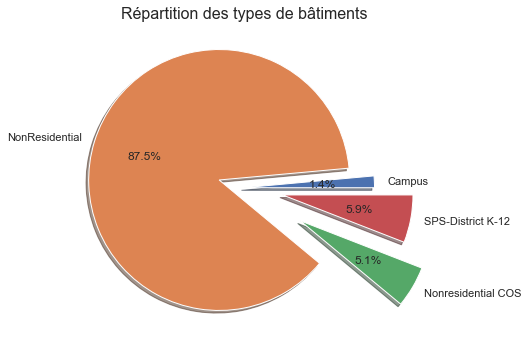

In [763]:
type_bat = df1.groupby(by='BuildingType')['OSEBuildingID'].nunique()
type_bat = type_bat[["Campus","NonResidential","Nonresidential COS","SPS-District K-12"]]
labels = type_bat.index
plt.figure(figsize =(6,6))
explode= 0,0.2,0.5,0.3
plt.title("Répartition des types de bâtiments",size = 16)
plt.pie(type_bat, labels=labels,autopct='%1.1f%%',explode=explode,shadow=True)

plt.show()

### Graphique de distribution des batiments par leur age

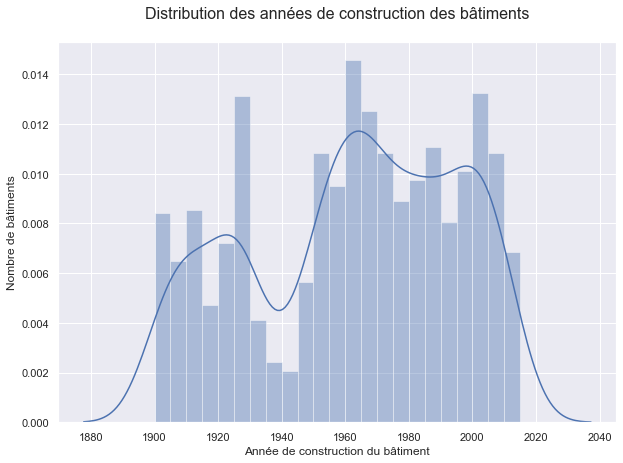

In [764]:
fig = plt.figure(figsize=(10,7))
ax = sns.distplot(df1['YearBuilt'], bins=int((df1.YearBuilt.max() - df1.YearBuilt.min())/5))
ax.set_xlabel("Année de construction du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", size =16)
plt.show()

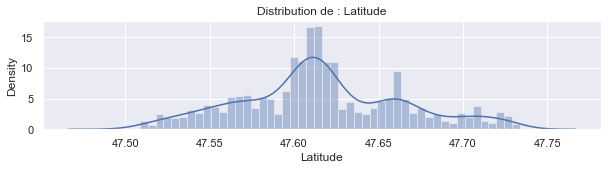

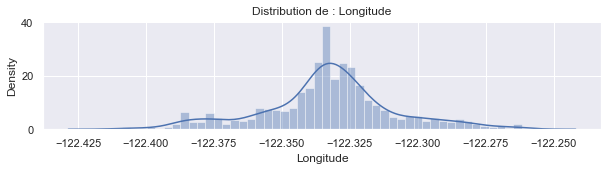

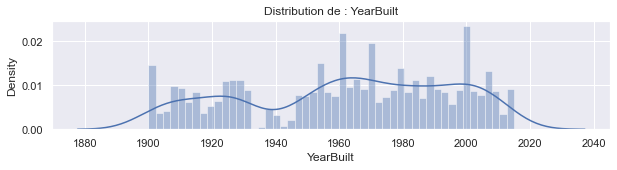

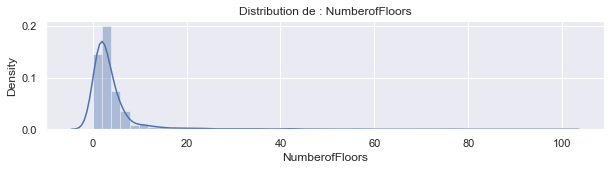

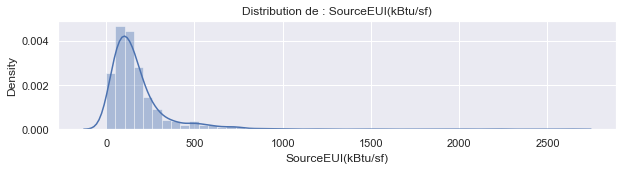

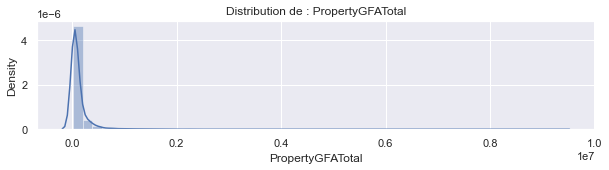

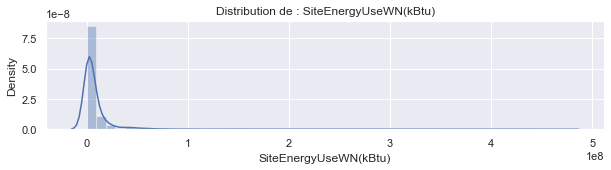

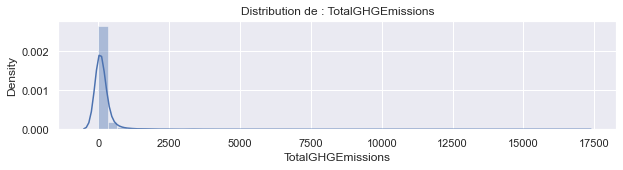

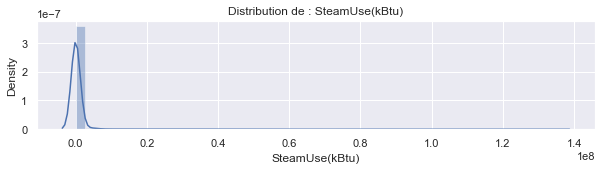

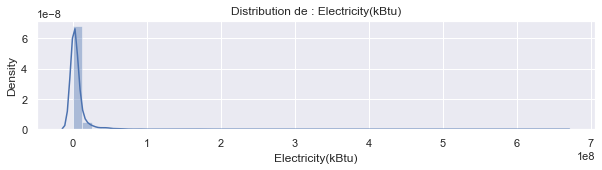

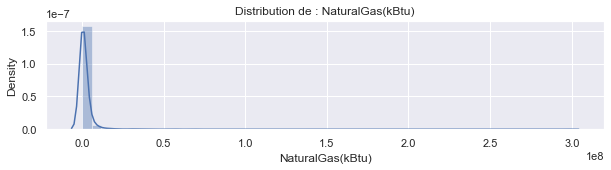

In [765]:
columns = ["Latitude","Longitude","YearBuilt","NumberofFloors","SourceEUI(kBtu/sf)","PropertyGFATotal",
           "SiteEnergyUseWN(kBtu)","TotalGHGEmissions","SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)"]
for column in columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.distplot(df1[column], bins=50)
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

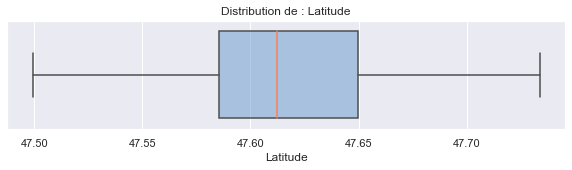

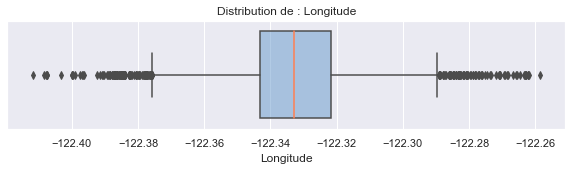

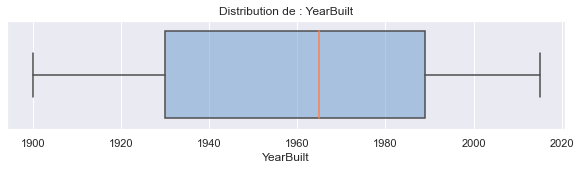

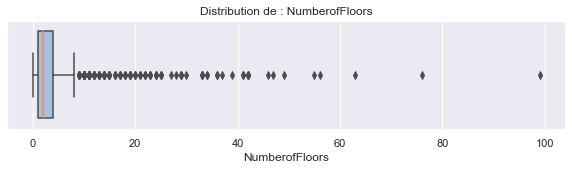

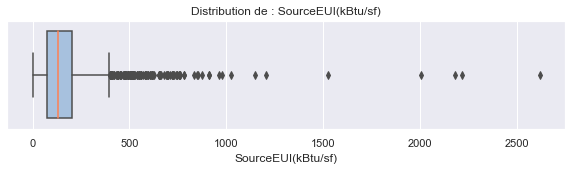

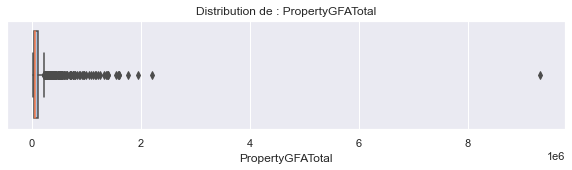

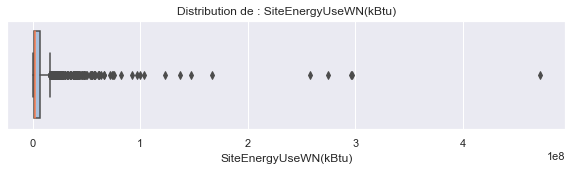

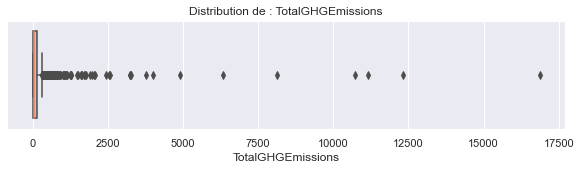

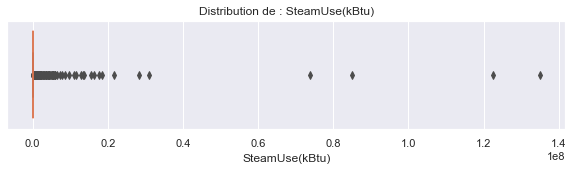

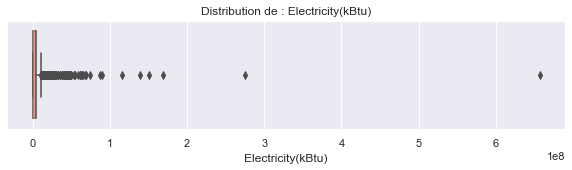

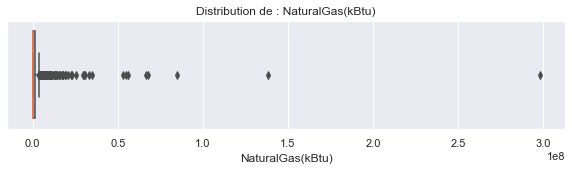

In [766]:
columns = ["Latitude","Longitude","YearBuilt","NumberofFloors","SourceEUI(kBtu/sf)","PropertyGFATotal",
           "SiteEnergyUseWN(kBtu)","TotalGHGEmissions","SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)"]
for column in columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.boxplot(x=df1[column],boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

#### Pour les 2 dernieres features on voit que les outliers posent problèmes, je vais donc calculer une valeur seuil à partir de l'écart interquartile

### Calcul de la valeur seuil pour SiteEnergyUseWN(kBtu) et TotalGHGEmissions

#### Pour SiteEnergyUseWN(kBtu)

In [767]:
Q1 = df1["SiteEnergyUseWN(kBtu)"].quantile(0.25)
Q2 = df1["SiteEnergyUseWN(kBtu)"].quantile(0.50)
Q3 = df1["SiteEnergyUseWN(kBtu)"].quantile(0.75)
IQR =  (Q3 - Q1)
limite_haute = (Q3 + 1.5 * IQR)
print("le 1er quartile se situe à",Q1)
print("le 2ème quartile se situe à",Q2)
print("le 3ème quartile se situe à",Q3)
print("l'écart interquartile est de",IQR)
print("la limite haute est de",limite_haute)

le 1er quartile se situe à 1294392.03125
le 2ème quartile se situe à 2679931.75
le 3ème quartile se situe à 7167892.625
l'écart interquartile est de 5873500.59375
la limite haute est de 15978143.515625


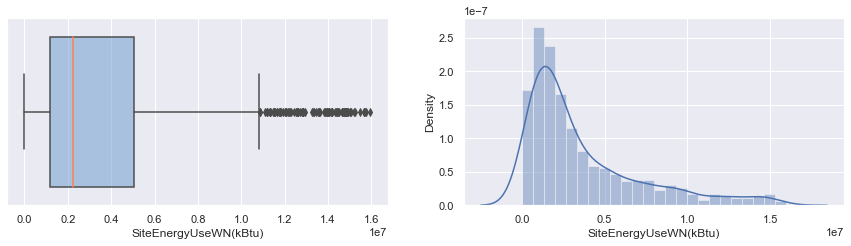

In [768]:
energy_filter =  df1["SiteEnergyUseWN(kBtu)"].where( df1["SiteEnergyUseWN(kBtu)"]<=limite_haute)
plt.figure(figsize = (15, 20))
plt.subplot(5,2,1)
sns.boxplot(x=energy_filter,boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
plt.subplot(5,2,2)
sns.distplot(energy_filter)
plt.show()

In [769]:
energy_filter.count()

1476

In [770]:
df2 = df1[df1['SiteEnergyUseWN(kBtu)'] < limite_haute]


#### Pour TotalGHGEmissions

In [771]:
Q1 = df2["TotalGHGEmissions"].quantile(0.25)
Q2 = df2["TotalGHGEmissions"].quantile(0.50)
Q3 = df2["TotalGHGEmissions"].quantile(0.75)
IQR =  (Q3 - Q1)
limite_haute1 = (Q3 + 1.5 * IQR)
print("le 1er quartile se situe à",Q1)
print("le 2ème quartile se situe à",Q2)
print("le 3ème quartile se situe à",Q3)
print("l'écart interquartile est de",IQR)
print("la limite haute est de",limite_haute1)

le 1er quartile se situe à 17.3875
le 2ème quartile se situe à 42.55
le 3ème quartile se situe à 94.7675
l'écart interquartile est de 77.38
la limite haute est de 210.83749999999998


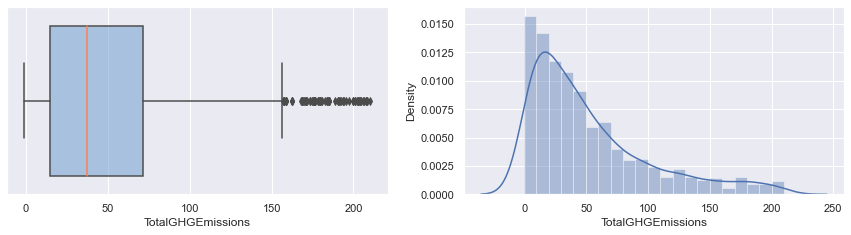

In [772]:
emission_filter =   df2["TotalGHGEmissions"].where(  df2["TotalGHGEmissions"]<=limite_haute1)
plt.figure(figsize = (15, 20))
plt.subplot(5,2,1)
sns.boxplot(x=emission_filter,boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
plt.subplot(5,2,2)
sns.distplot(emission_filter)
plt.show()

In [773]:
emission_filter.count()

1334

### Distribution une fois le filtrage fait sur la limite haute des emissions totales de CO2

In [774]:
df2 = df2[df2["TotalGHGEmissions"] < limite_haute1]
df2.shape

(1334, 22)

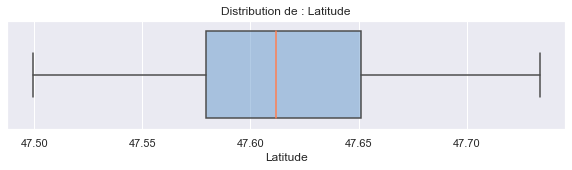

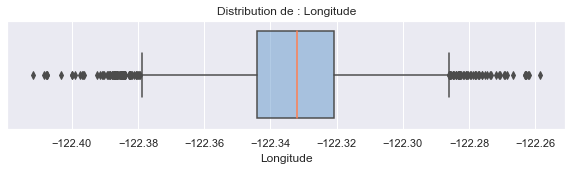

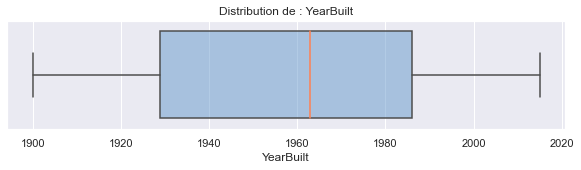

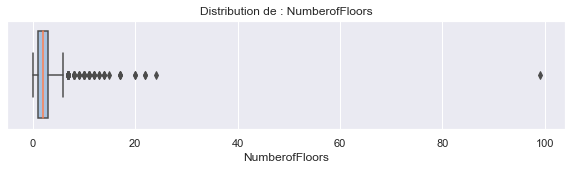

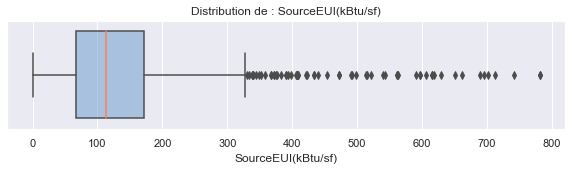

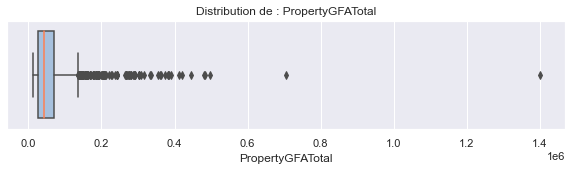

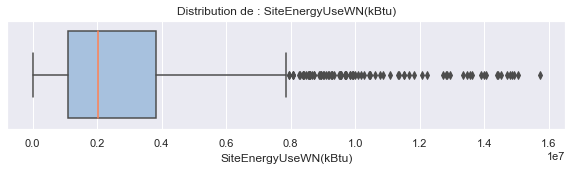

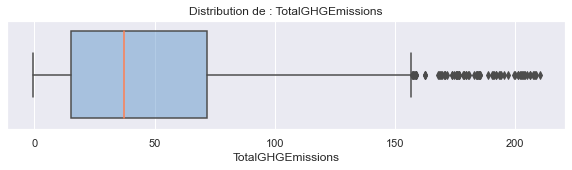

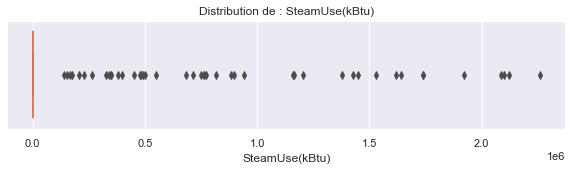

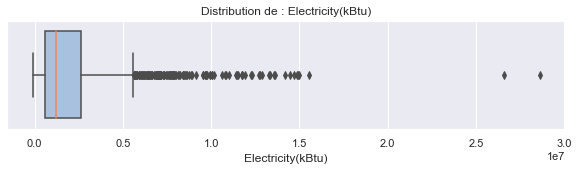

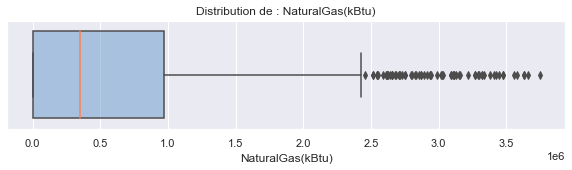

In [775]:
columns = ["Latitude","Longitude","YearBuilt","NumberofFloors","SourceEUI(kBtu/sf)","PropertyGFATotal",
           "SiteEnergyUseWN(kBtu)","TotalGHGEmissions","SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)"]
for column in columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.boxplot(x=df2[column],boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

### Distributions  des emissions de CO2 et de la consommation d'energie en fonction du quartier

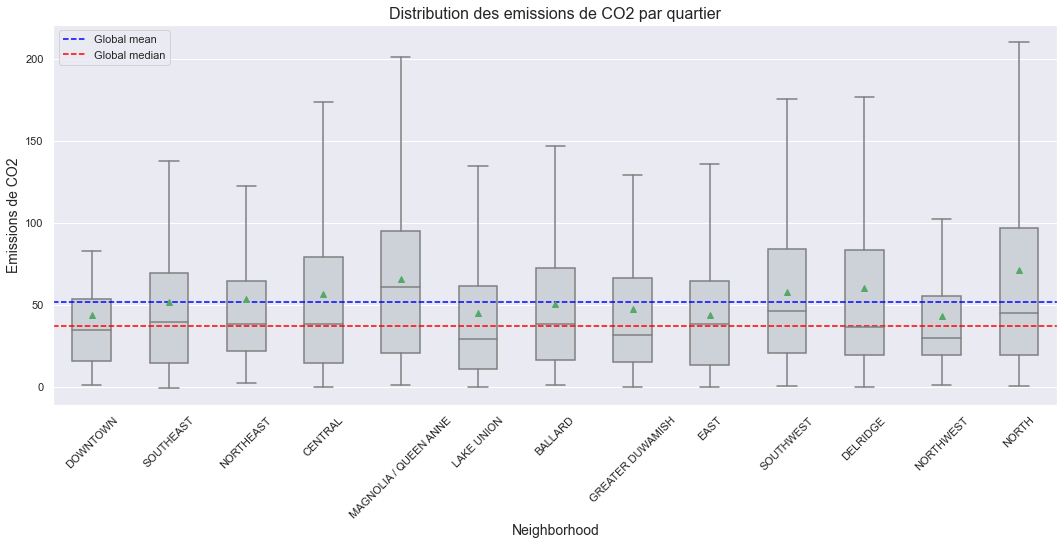

In [776]:
the_mean=df2["TotalGHGEmissions"].mean()
the_median = df2["TotalGHGEmissions"].median()
plt.figure(figsize=[18,7])
    
plt.title("Distribution des emissions de CO2 par quartier",size=16)
sns.boxplot(x=df2['Neighborhood'], y="TotalGHGEmissions", data=df2,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
plt.hlines(y=the_mean,xmin=-0.5,xmax=len(df2['Neighborhood'].unique())-0.5,color="blue",ls="--",label="Global mean")
plt.hlines(y=the_median,xmin=-0.5,xmax=len(df2['Neighborhood'].unique())-0.5,color="red",ls="--",label="Global median")
    
plt.ylabel("Emissions de CO2",size=14)
plt.xticks(range(0,len(df2['Neighborhood'].unique()))
               ,df2['Neighborhood'].unique(),rotation=45)
plt.xlabel('Neighborhood',size=14)
plt.legend()
plt.show()

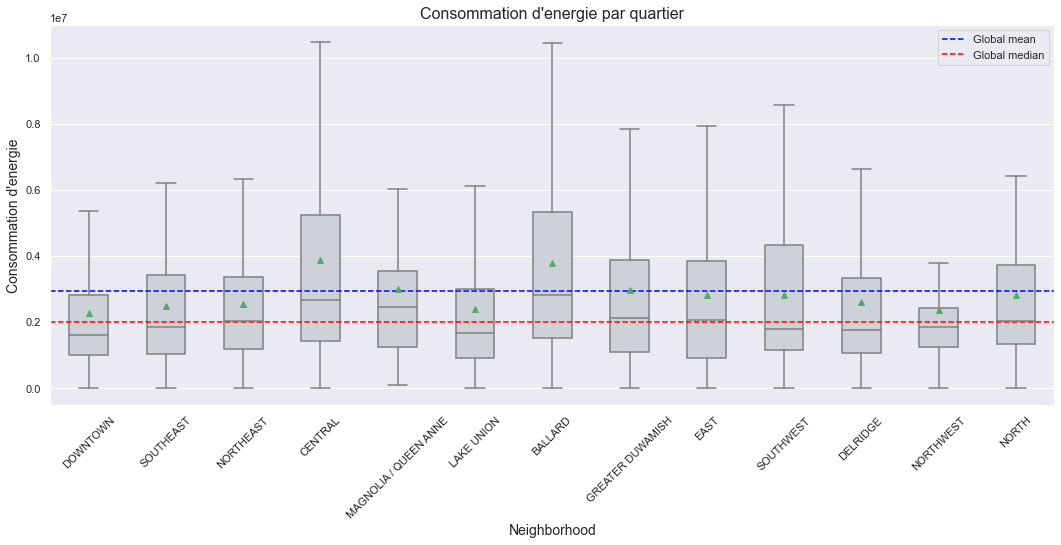

In [777]:
the_mean=df2['SiteEnergyUseWN(kBtu)'].mean()
the_median = df2['SiteEnergyUseWN(kBtu)'].median()
plt.figure(figsize=[18,7])
    
plt.title("Consommation d'energie par quartier",size=16)
sns.boxplot(x=df2['Neighborhood'], y='SiteEnergyUseWN(kBtu)', data=df2,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
plt.hlines(y=the_mean,xmin=-0.5,xmax=len(df2['Neighborhood'].unique())-0.5,color="blue",ls="--",label="Global mean")
plt.hlines(y=the_median,xmin=-0.5,xmax=len(df2['Neighborhood'].unique())-0.5,color="red",ls="--",label="Global median")
    
plt.ylabel("Consommation d'energie",size=14)
plt.xticks(range(0,len(df2['Neighborhood'].unique()))
               ,df2['Neighborhood'].unique(),rotation=45)
plt.xlabel('Neighborhood',size=14)
plt.legend()
plt.show()

 ### Distributions des emissions de CO2 et de la consommation d'energie en fonction du type de batiments

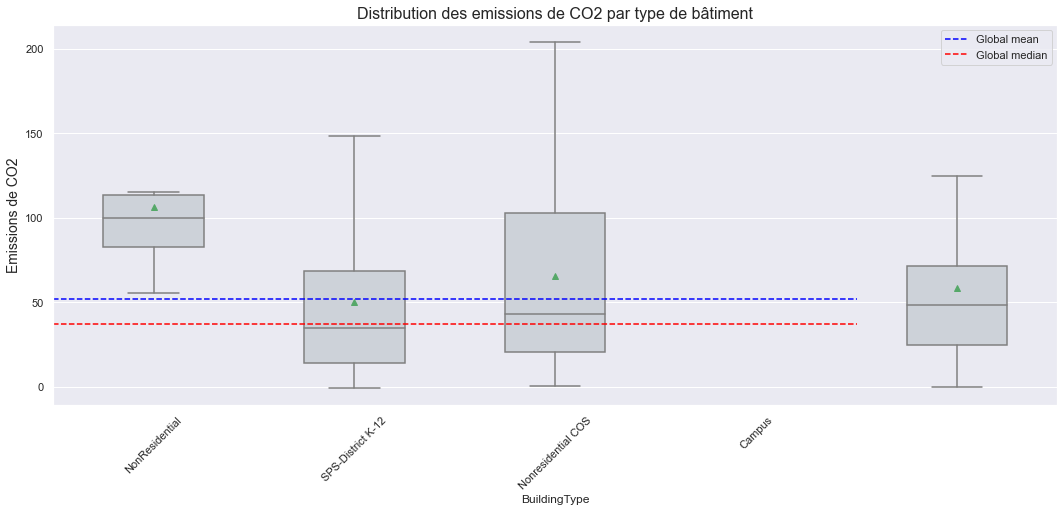

In [778]:
the_mean=df2["TotalGHGEmissions"].mean()
the_median = df2["TotalGHGEmissions"].median()
plt.figure(figsize=[18,7])
plt.title("Distribution des emissions de CO2 par type de bâtiment",size=16)
sns.boxplot(x=df2['BuildingType'], y="TotalGHGEmissions", data=df2,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
plt.hlines(y=the_mean,xmin=-0.5,xmax=len(df2['BuildingType'].unique())-0.5,color="blue",ls="--",label="Global mean")
plt.hlines(y=the_median,xmin=-0.5,xmax=len(df2['BuildingType'].unique())-0.5,color="red",ls="--",label="Global median")
   
plt.ylabel("Emissions de CO2",size=14)
plt.xticks(range(0,len(df2['BuildingType'].unique()))
               ,df2['BuildingType'].unique(),rotation=45)
plt.legend()
plt.show()

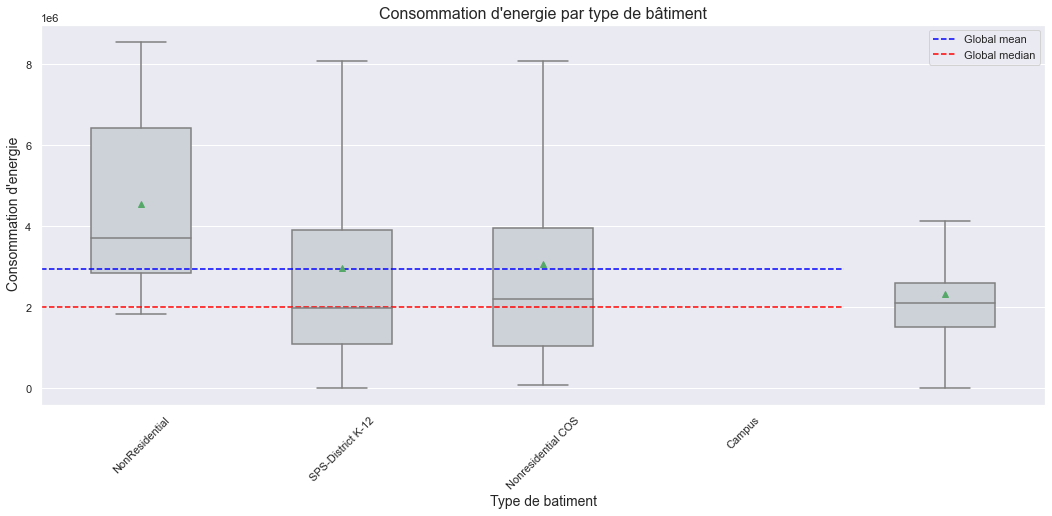

In [779]:
the_mean=df2['SiteEnergyUseWN(kBtu)'].mean()
the_median = df2['SiteEnergyUseWN(kBtu)'].median()
plt.figure(figsize=[18,7])
plt.title("Consommation d'energie par type de bâtiment",size=16)
sns.boxplot(x=df2['BuildingType'], y='SiteEnergyUseWN(kBtu)', data=df2,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
plt.hlines(y=the_mean,xmin=-0.5,xmax=len(df2['BuildingType'].unique())-0.5,color="blue",ls="--",label="Global mean")
plt.hlines(y=the_median,xmin=-0.5,xmax=len(df2['BuildingType'].unique())-0.5,color="red",ls="--",label="Global median")
   
plt.ylabel(" Consommation d'energie",size=14)
plt.xticks(range(0,len(df2['BuildingType'].unique()))
               ,df2['BuildingType'].unique(),rotation=45)
plt.xlabel("Type de batiment", size=14)
plt.legend()
plt.show()

### Répartition du nombre de batiments par quartier

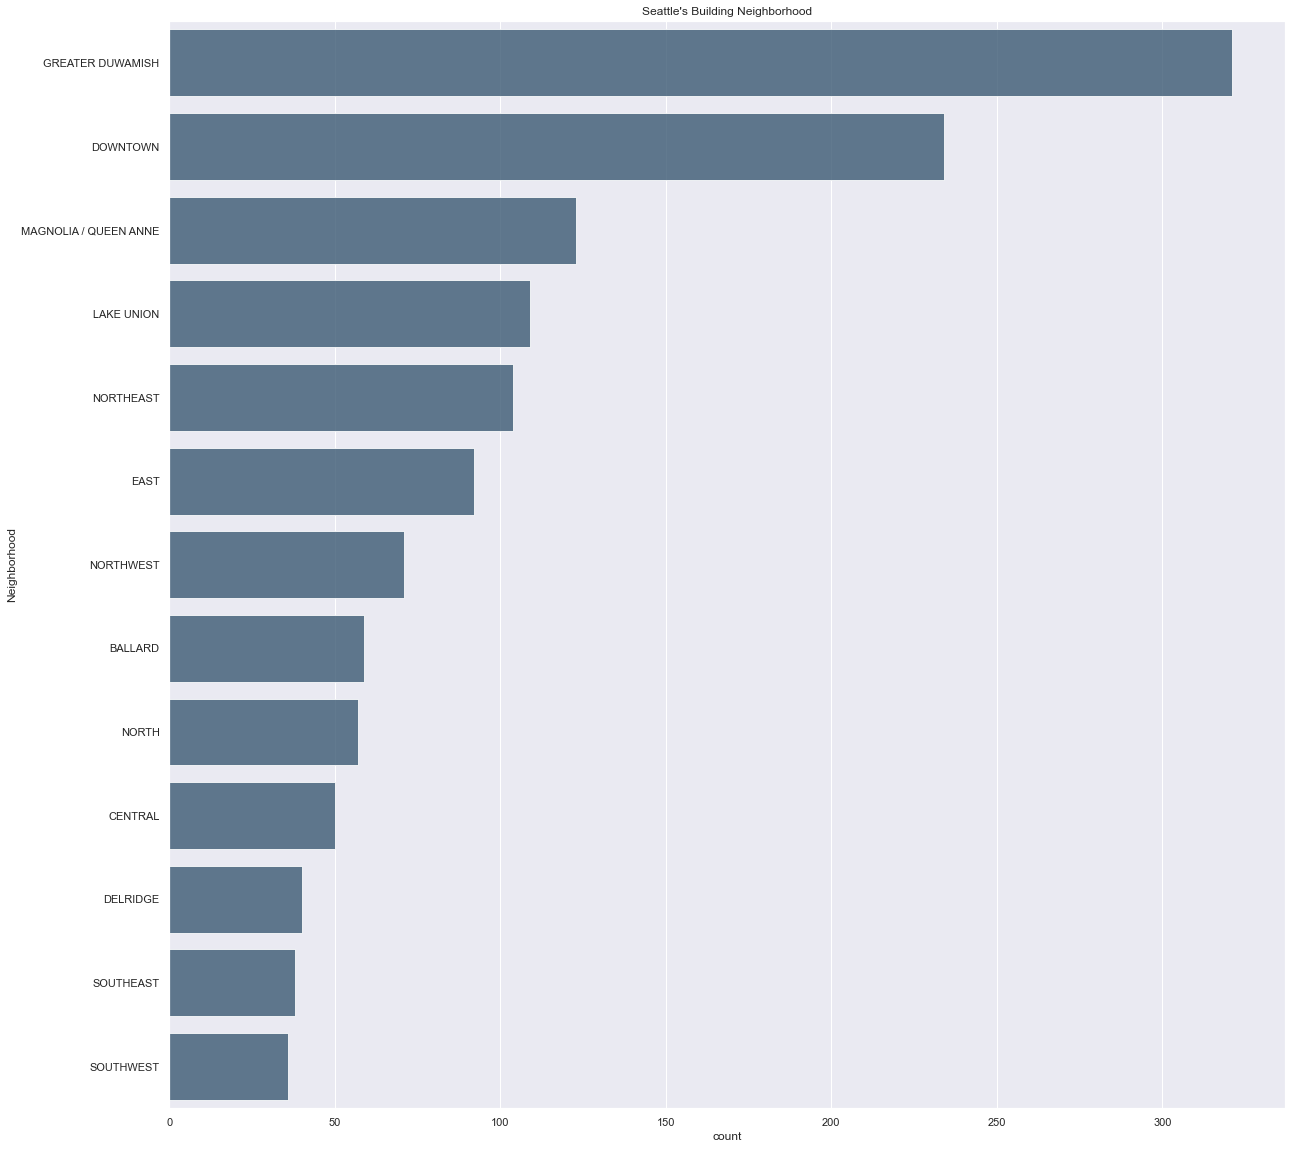

In [780]:
ax, fig = plt.subplots(figsize=(20,20)) 
ax = sns.countplot(data=df2, y='Neighborhood', color="#315a7d", alpha=.8,
              order=df2['Neighborhood'].value_counts().index, orient='horizontal')
ax.set_title("Seattle's Building Neighborhood")
plt.show()

### Répartition du nombre de batiments par District

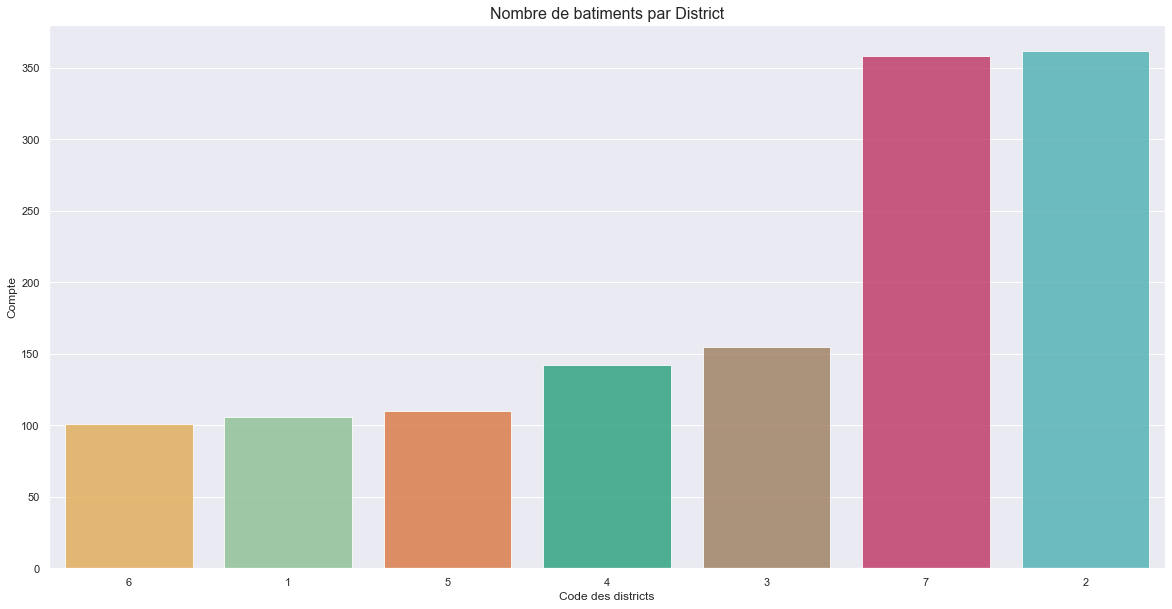

In [781]:
plt.subplots(figsize=(20,10)) 
code_colors = {7:'#d41c5c', 3:'#a77c52', 2:'#3cc0c2', 4:'#13b383', 5:'#f36f25', 1:'#82c88c', 6:'#f8af3c'}
sns.countplot(data=df2, x='CouncilDistrictCode', palette=code_colors, alpha=.8,
                   order=list(df2['CouncilDistrictCode'].value_counts(ascending= True).index))
plt.title("Nombre de batiments par District",size=16)
plt.xlabel("Code des districts")
plt.ylabel("Compte")
plt.show()

### Matrice de corrélation

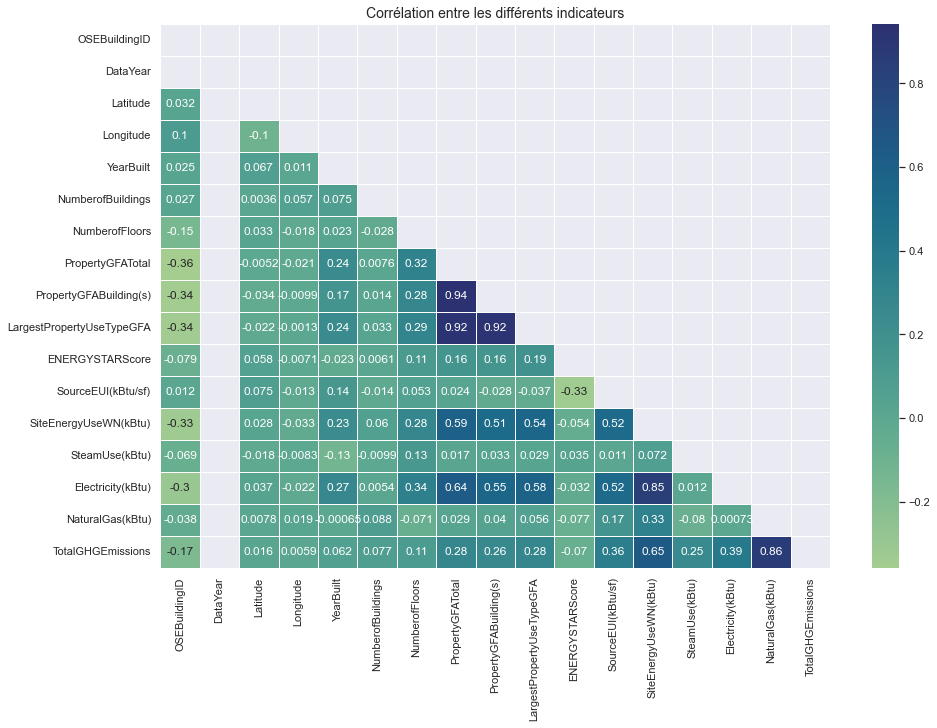

In [782]:
plt.figure(figsize=(15,10))
corr = df2.corr()
matrix = np.triu(corr)
sns.heatmap( corr,cmap='crest',annot=True,linewidth=.5,mask=matrix )
plt.title('Corrélation entre les différents indicateurs',size = 14)
plt.show()

### Tableau des corrélations par pairs


In [783]:
threshold = 0.6
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
12,PropertyGFABuilding(s),PropertyGFATotal,0.942015
10,PropertyGFATotal,LargestPropertyUseTypeGFA,0.924621
8,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.916944
6,TotalGHGEmissions,NaturalGas(kBtu),0.863669
4,Electricity(kBtu),SiteEnergyUseWN(kBtu),0.845332
2,TotalGHGEmissions,SiteEnergyUseWN(kBtu),0.645508
0,Electricity(kBtu),PropertyGFATotal,0.636507


### Suppression de certaines colonnes trop corrélées

In [784]:
df2.drop(["PropertyGFABuilding(s)","LargestPropertyUseTypeGFA"], axis=1, inplace=True)

POUR ELECTRICITY ET NATURALGAS , ON VA VOIR LEUR INFLUENCE EN LES ENLEVANT OU PAS DANS CHAQUE PREDICTION

### Distribution des 2 targets

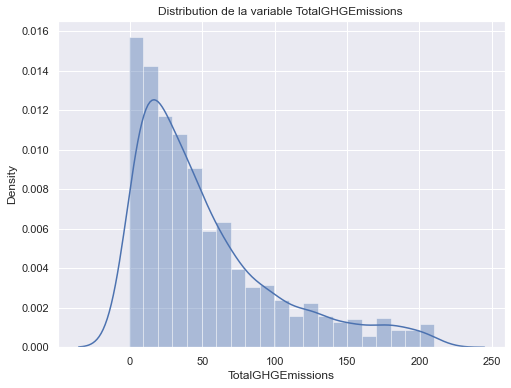

In [787]:
plt.figure(figsize= (8,6))
sns.distplot(df2['TotalGHGEmissions'])
plt.title('Distribution de la variable TotalGHGEmissions ')
plt.show()

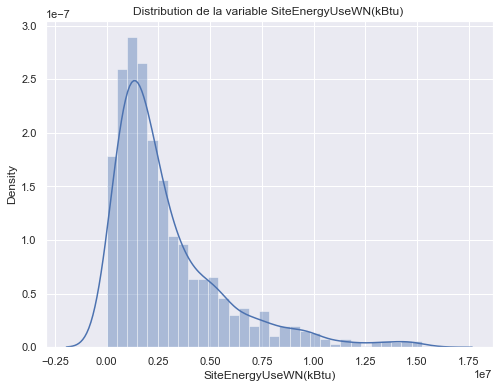

In [788]:
plt.figure(figsize= (8,6))
sns.distplot(df2['SiteEnergyUseWN(kBtu)'])
plt.title('Distribution de la variable SiteEnergyUseWN(kBtu) ')
plt.show()